In [ ]:
# This file aims to display some functions regarding Brightway 2.5, to demonstrate what can be done with the software when you have a foreground model matched with ecoinvent's bio- and technosphere.

# Analysis

### 1. Loading the project

In [ ]:
# basic imports from brightway
import bw2analyzer as ba
import bw2calc as bc
import bw2data as bd
import bw2io as bi
from bw2io.importers import SingleOutputEcospold2Importer
import bw2analyzer as bwa
from bw2data import methods

# other relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

In [ ]:
# define a project where we install the databases and work in this script
bd.projects.set_current('brightway25')

### 2. Database overview

In [ ]:
bd.databases

In [ ]:
bd.projects.current

In [ ]:
ei_clca = bd.Database('ecoinvent310clca')
ei_bio = bd.Database('ecoinvent-3.10-biosphere')
db_template = bd.Database('bw25_db')
el_bio3 = bd.Database('biosphere3')

### 3. Database exploration

In [23]:
db_template.search('ceramics')

['porcelain ceramics production' (kilogram, RER, None)]

In [ ]:
ei_clca.search('market group for electricity GLO')

In [24]:
# define a process as object in the project
ceramics = db_template.get(name = 'porcelain ceramics production', location = "RER", unit = 'kilogram')


In [ ]:
ceramics_ei = ei_clca.get(name = 'market for sanitary ceramics', location = "GLO", unit = 'kilogram')

### 4. Impact assessment methods

In [25]:
lcia_gwp100 = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')
lcia_water = ('EF v3.1','water use','user deprivation potential (deprivation-weighted water consumption)')
lcia_land = ('EF v3.1', 'land use', 'soil quality index')

### 4. LCI 

In [26]:
# export the LCI to e
bi.export.excel.write_lci_excel(db_template.name,
                                objs=[ceramics],
                                dirpath=Path.cwd())

'c:\\Users\\TimWeber\\repos_20LCA\\brightway25\\lci-bw25_db.xlsx'

### 5. LCIA

In [27]:
# Quick LCIA calculation
ceramics_lca = ceramics.lca(lcia_gwp100)
ceramics_lca.score


0.7265791393172016

### 6. Contribution analysis

In [28]:
# One option to do a contribution analysis is to use the recursive calculation method
bwa.print_recursive_calculation(ceramics,
lcia_method=lcia_gwp100,max_level=3,cutoff=0.05)

Fraction of score | Absolute score | Amount | Activity
0001 | 0.7266 |     1 | 'porcelain ceramics production' (kilogram, RER, None)
  00.2 | 0.1451 | 0.5775 | 'market for kaolin' (kilogram, GLO, None)
    0.123 | 0.08954 | 0.3783 | 'kaolin production' (kilogram, RoW, None)
      0.0546 | 0.0397 | 0.05354 | 'market group for electricity, medium voltage' (kilowatt hour, RAS, None)
    0.0699 | 0.05079 | 0.1992 | 'kaolin production' (kilogram, RER, None)
  0.331 | 0.2407 | 1.028 | 'market group for electricity, high voltage' (kilowatt hour, RER, None)
    0.327 | 0.2376 | 1.013 | 'market group for electricity, high voltage' (kilowatt hour, Europe without Switzerland, None)
      0.124 | 0.08975 | 0.1495 | 'market for electricity, high voltage' (kilowatt hour, UA, None)
  0.389 | 0.283 | 0.4507 | 'market group for natural gas, high pressure' (cubic meter, Europe without Switzerland, None)
    0.0665 | 0.04834 | 0.06835 | 'market for natural gas, high pressure' (cubic meter, IT, None)
    

In [29]:
# Another option is to use the recursive calculation to an object, which returns a DataFrame
ceramics_ca_gwp = bwa.utils.recursive_calculation_to_object(ceramics,
                                          lcia_method=lcia_gwp100,
                                          max_level=1,
                                          cutoff=0.02,
                                          as_dataframe=True,
                                          )
ceramics_ca_gwp

,label,parent,score,fraction,amount,name,key
0,root,None,0.726579,1.000000,1.000000e+00,porcelain ceramics production,"(bw25_db, a1b7153986d8f8387752b14278a0b4c2)"
1,root_a,root,0.145070,0.199662,5.775000e-01,market for kaolin,"(ecoinvent310clca, ab4384f247d3857b5d30e291407..."
2,root_b,root,0.015081,0.020756,2.750000e-01,market for feldspar,"(ecoinvent310clca, d1b241d797d752c6515a7bb3d13..."
3,root_d,root,0.240714,0.331297,1.027700e+00,"market group for electricity, high voltage","(ecoinvent310clca, 1e1014b29f9e44d8265fcd8d871..."
4,root_e,root,0.282982,0.389472,4.506667e-01,"market group for natural gas, high pressure","(ecoinvent310clca, 1fc2418e39967f8ff8432afc4b6..."
5,root_f,root,0.031445,0.043279,1.250000e-10,packaging glass factory construction,"(ecoinvent310clca, d1d37459bfab78d834c25f0a808..."


In [30]:
# Elementary flows contribution analysis by process
ceramics_lca.to_dataframe().pivot_table(index=['col_name', 'row_name'], values='amount', aggfunc='sum').sort_values(by='amount', ascending=False)

,,amount
col_name,row_name,
natural gas venting from petroleum/natural gas production,"Methane, fossil",0.098833
"electricity production, natural gas, combined cycle power plant","Carbon dioxide, fossil",0.093307
"electricity production, lignite","Carbon dioxide, fossil",0.071315
"heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical","Carbon dioxide, fossil",0.067546
"natural gas, burned in gas turbine","Carbon dioxide, fossil",0.058441
...,...,...
hard coal mine operation,"Carbon dioxide, fossil",0.000344
"treatment of blast furnace gas, in power plant","Carbon dioxide, fossil",0.000340
"heat production, natural gas, at industrial furnace >100kW","Carbon dioxide, fossil",0.000263


In [31]:
# Elementary flows contribution analysis as summary table
ceramics_lca.to_dataframe().pivot_table(index='row_name',values='amount',aggfunc='sum')

,amount
row_name,
"Carbon dioxide, fossil",0.524682
Dinitrogen monoxide,0.001086
"Methane, fossil",0.155425
Trifluoromethane,0.000743


### 7. Plot Contribution analysis graphs

In [32]:
# Filter out the parent processes that are not relevant for the contribution analysis
ceramics_ca_gwp = ceramics_ca_gwp.dropna(subset='parent') 



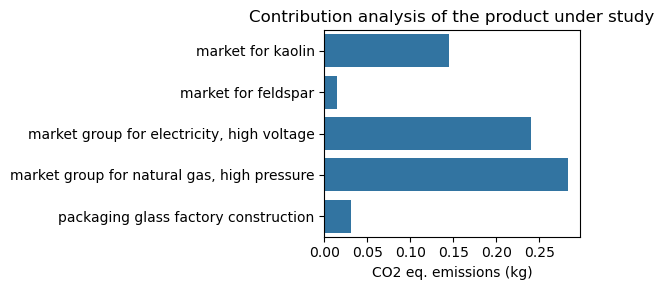

In [35]:
f, ax = plt.subplots(figsize=(6, 3))
sns.barplot(y='name', x='score', data=ceramics_ca_gwp, ax=ax)
ax.set(
    title='Contribution analysis of the product under study',
    xlabel='CO2 eq. emissions (kg)',
    ylabel='')
plt.tight_layout()
plt.show()
